In [245]:
#May 25

import ares
import numpy as np
import matplotlib.pyplot as pl

In [246]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

### DPL SMF relation  
Following from Moster2010  
I thought I needed to do:  
$\phi ~[~/Mpc^3 dex^{-1}] = \frac{m(M)}{M} \cdot \frac{dn}{dm}$  
But I still don't seem to get the smaller curvature (also not well aligned on y axis)

In [247]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of the mM_ratio wrt M
def dr_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = -2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

# finite difference of the mM_ratio wrt M with 
def finite_dif(mM_ratio):
    diff = []
    for i in range(len(mM_ratio)-1):
        diff.append( (mM_ratio[i+1] - mM_ratio[i])/(pop_halo.halos.tab_M[i+1] - pop_halo.halos.tab_M[i]) )
    return diff

In [248]:
#double power law
def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, diff=False):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) #equ 2
    
    """
    tab_dndm (halo) -> dndm (SM)
    need: tab_dndm * d(ratio)/dM
    """
    
    #to try either the analytic or finite derivative
    if diff:
        SMF = pop_halo.halos.tab_dndm[k, :][:-1] * finite_dif(mM_ratio)
    else:
        SMF = pop_halo.halos.tab_dndm[k, :] * dr_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #HMF * m/M
#     SMF = pop_halo.halos.tab_dndm[k, :] * mM_ratio #HMF * m/M

#     SMF = []
#     dif = []

#     for i, r in enumerate(mM_ratio):
#         SMF.append(pop_halo.halos.tab_dndm[k, :][i] * r) #HMF * m/M
#         dif.append(SMF[-1] - pop_halo.halos.tab_dndm[k, :][i])

    return SMF,  mM_ratio #, dif

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=stefanon2017
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=duncan2014


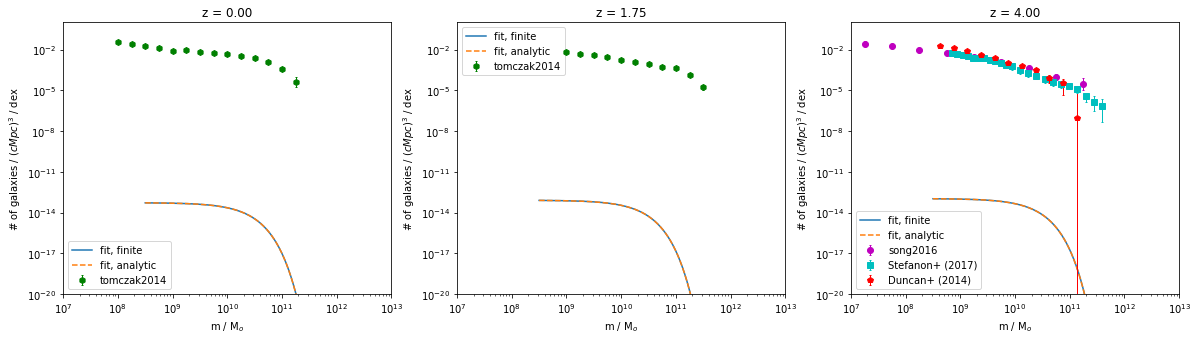

In [249]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

#From Moster2010, table 1
N = 0.02820
M_1 = 10**11.884 #np.exp(11.884)
beta = 1.057
gamma = 0.556

for i, z in enumerate([0, 1.75, 4]):
   
    data.PlotSMF(z=z, round_z=0.4, ax=axs[i])

    SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, True)
    SMF_a, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)


    SM = np.linspace(10**8.5, 10**11.85, num=len(SMF))
    SM_a = np.linspace(10**8.5, 10**11.85, num=len(SMF_a))

#     SM = np.logspace(8.5, 11.85, num=len(SMF))
#     SM = pop_halo.halos.tab_M
#     SM = r*pop_halo.halos.tab_M

    axs[i].loglog(SM, SMF, label='fit, finite')
    axs[i].loglog(SM_a, SMF_a, label='fit, analytic', ls="--")
    
    #plotting just offset HMF for comparison
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))
#     axs[i].loglog(SM, pop_halo.halos.tab_dndm[zz, :]*0.05, ls = "--", label='hmf 0.05 offset')

    axs[i].set_title("z = %.2f" %z)
    axs[i].legend()
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-20, 1e0)
#     axs[i].set_xlim(-35, 0)

pl.show()

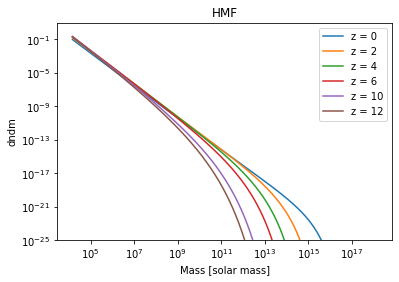

In [250]:
#is there something here that doesn't match up with the paper?
for z in [0, 2, 4, 6, 10, 12]:
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*0.05, label='z = %i' %z)
    
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

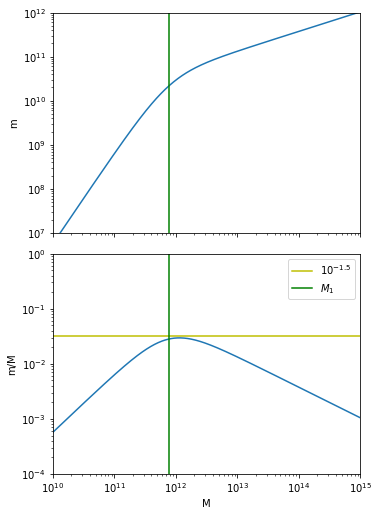

In [251]:
#looking at the SHM ratio m/M  - matches Fig 4

fig, axs = pl.subplots(2, 1, figsize=(5, 7), sharex=True)
fig.tight_layout()
i = 0

SMF, ratio = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma) #* pop_halo.halos.tab_M

SM = pop_halo.halos.tab_M

axs[i].loglog(SM, ratio*pop_halo.halos.tab_M)#, label='c = %.e' %c)

axs[i].set(ylabel='m')
axs[i].set_ylim(1e7, 1e12)
axs[i].set_xlim(1e10, 1e15)
axs[i].axvline(M_1, color="g", label="M_1")


i = 1
axs[i].loglog(SM, ratio)#, label='c = %.e' %c)

axs[i].set(xlabel='M', ylabel='m/M')
axs[i].set_ylim(1e-4, 1e0)
axs[i].set_xlim(1e10, 1e15)
axs[i].axhline(10.0**(-1.5), color="y", label="$10^{-1.5}$")
axs[i].axvline(M_1, color="g", label="$M_1$")

axs[i].legend()

pl.show()

In [252]:
def SMF_b(z, pop_halo, N, M_1, beta):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta)) #equ 2
    
    #is this right?
    SMF = pop_halo.halos.tab_dndm[k, :] * mM_ratio #HMF * m/M

    return SMF,  mM_ratio

def SMF_g(z, pop_halo, N, M_1, gamma):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = 2*N / ((pop_halo.halos.tab_M/M_1)**(gamma) ) #equ 2
    
    #is this right?
    SMF = pop_halo.halos.tab_dndm[k, :] * mM_ratio #HMF * m/M

    return SMF,  mM_ratio

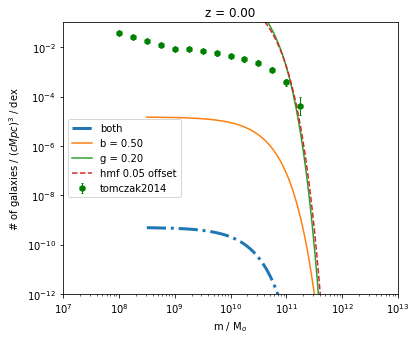

In [253]:
#playing around with the DPL params myself

fig, axs = pl.subplots(1, 1, figsize=(6, 5))

#From Moster2010, table 1
N = 0.02820
M_1 = 10**11.884 #np.exp(11.884)
beta = .5
gamma = .2

for i, z in enumerate([0]):
   
    data.PlotSMF(z=z, round_z=0.4, ax=axs)

#     for c in [1e-4, 1, 1e2, 1e3, 1e4]:
    SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)

    SMFb, r1 = SMF_b(z, pop_halo, N, M_1, beta)
    SMFg, r2 = SMF_g(z, pop_halo, N, M_1, gamma)

    SM = np.linspace(10**8.5, 10**11.95, num=len(SMFb))
#     SM = np.logspace(8.5, 11.85, num=len(SMF))
#     SM = pop_halo.halos.tab_M

    axs.loglog(SM, SMF, label='both', ls="-.", linewidth=3)
    axs.loglog(SM, SMFb, label='b = %.2f' %beta)
    axs.loglog(SM, SMFg, label='g = %.2f' %gamma)

    
    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    axs.loglog(SM, pop_halo.halos.tab_dndm[zz, :], ls = "--", label='hmf 0.05 offset')

    axs.set_title("z = %.2f" %z)
    axs.legend()
    axs.set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs.set_ylim(1e-12, 1e-1)
#     axs[i].set_xlim(-35, 0)

pl.show()

Looking at bin sizes and trying to build SM off of HM using the same size bins

In [259]:
SM = np.linspace(10**8.5, 10**11.95, num=len(SMFb))

dM = []
for i in range(len(pop_halo.halos.tab_M)-1):
    dM.append( (pop_halo.halos.tab_M[i+1] - pop_halo.halos.tab_M[i])*r[i])

dm = SM[1] - SM[0]
#but I don't really know how to get the right amount of counts in each new bin based on the change of size this way

(1e-50, 0.1)

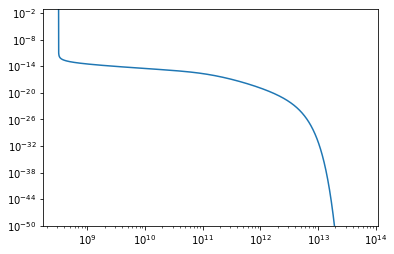

In [260]:
SM_steps = [10**8.5]
for i in dM:
    SM_steps.append(SM_steps[-1] + i)
    
# pl.semilogy(SM_steps)
pl.loglog(SM_steps, SMF, label='both')
pl.ylim(1e-50, 1e-1)

Trying to do rebining with change of vars as probs

$dm/dM = \frac{d}{dM} (M \cdot m(M))$

In [256]:
def SMF_prob(z, pop_halo, N, M_1, beta, gamma):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) #equ 2
    
    mass = mM_ratio*pop_halo.halos.tab_M
    
    SMF = pop_halo.halos.tab_dndm[k, :] * mM_ratio / np.abs(dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio))#HMF * m/M

    return SMF,  mM_ratio, mass

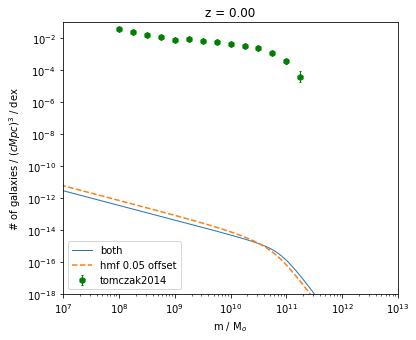

In [257]:
fig, axs = pl.subplots(1, 1, figsize=(6, 5))

#From Moster2010, table 1
N = 0.02820
M_1 = 10**11.884 #np.exp(11.884)
beta = 1.057
gamma = 0.556

# print((pop_halo.halos.tab_M/M_1))

for i, z in enumerate([0]):
   
    data.PlotSMF(z=z, round_z=0.4, ax=axs)

    SMF, r, mass = SMF_prob(z, pop_halo, N, M_1, beta, gamma)

#     SM = np.linspace(10**8.5, 10**11.95, num=len(SMFb))
#     SM = np.logspace(8.5, 11.85, num=len(SMF))
#     SM = pop_halo.halos.tab_M

    axs.loglog(mass, SMF, label='both', ls="-", linewidth=1)

    zz = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    axs.loglog(mass, pop_halo.halos.tab_dndm[zz, :], ls = "--", label='hmf 0.05 offset')

    axs.set_title("z = %.2f" %z)
    axs.legend()
    axs.set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs.set_ylim(1e-18, 1e-1)
#     axs[i].set_xlim(-35, 0)

pl.show()